# Imports

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'


# Load datasets



> [provided code]

In [ ]:
dataset_dir = "https://raw.githubusercontent.com/probml/pmtkdata/master/knnClassify3c/"
train_dataset_path = dataset_dir + "knnClassify3cTrain.txt"
test_dataset_path = dataset_dir + "knnClassify3cTest.txt"

# Train dataset
train_dataset = pd.read_csv(train_dataset_path,
names=["x1", "x2", "class"],
delimiter=" ")
X_train = train_dataset.iloc[:, :-1].values
y_train = train_dataset.iloc[:, -1].values

# Test dataset
test_dataset = pd.read_csv(test_dataset_path, names=["x1", "x2", "class"], 
                           delimiter=" ")
X_test = test_dataset.iloc[:, :-1].values
y_test = test_dataset.iloc[:, -1].values

In [ ]:
train_dataset.shape
train_dataset.info()
train_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      200 non-null    float64
 1   x2      200 non-null    float64
 2   class   200 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 4.8 KB


,x1,x2,class
count,200.000000,200.000000,200.000000
mean,0.636060,1.828776,2.100000
std,1.411033,1.678331,0.832747
min,-3.060700,-2.098700,1.000000
25%,-0.392375,0.421600,1.000000
50%,0.490850,1.980150,2.000000
75%,1.768975,3.156400,3.000000
max,3.631500,5.404900,3.000000


# Q1

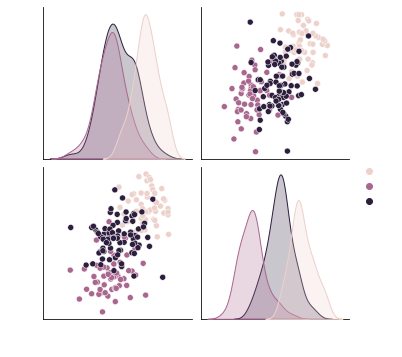

In [ ]:
sns.pairplot(train_dataset, hue='class')

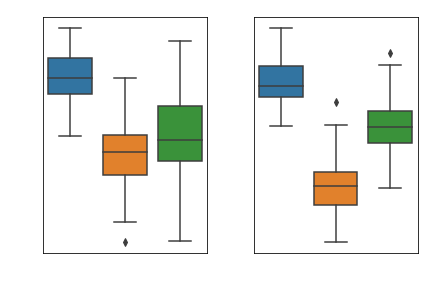

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

for i, feature in enumerate(train_dataset.iloc[:,:-1]):
    sns.boxplot(x='class', y=feature, data=train_dataset, ax=ax[i])
_ = fig.suptitle("Numerical Feature Distributions", y=1)
fig.tight_layout()

# Q2

In [ ]:
class classificationRules:
    def predict(self, x_1, x_2):
        if (x_1 >= 1.5 and x_2 >= 3): my_class=1
        elif x_2<=1: my_class = 2
        else: my_class = 3
        return my_class

# Q3


In [ ]:
# this function doesn't work with classifiers other than "classificationRules"
def get_misclass_rate(X,y,predictor):
    y_pred = [predictor.predict(x_1, x_2) for x_1, x_2 in X]
    return np.mean(y_pred != y)

print(f'misclassification rate: {get_misclass_rate(X=X_test, y=y_test, predictor=classificationRules())}')

misclassification rate: 0.272


# Q4

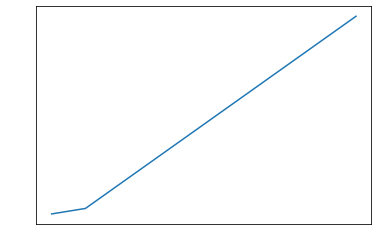

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 

K, misclassification_rate = [1, 5, 10], []

for k in K:
    sk_knn = KNeighborsClassifier(n_neighbors=k)
    _ = sk_knn.fit(X_train, y_train)
    y_pred = sk_knn.predict(X_test)
    misclassification_rate.append(np.mean(y_pred != y_test))

plt.plot([1/k for k in K], misclassification_rate)



# Q5

> [provided code]

In [ ]:
class KNearestNeighbors:
    """
    Simple implementation of a k-NN estimator.
    """
    def __init__(self, n_neighbors: int = 1) -> None:
        self.k = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Set the train dataset attributes to be used for prediction.
        """
        self.X_train = X_train
        self.y_train = y_train

    def get_neighbor_classes(self, observation: np.ndarray) -> np.ndarray:
        """
        Returns an array of the classes of the *k* nearest neighbors.
        """
        distances = np.sqrt(np.sum((self.X_train - observation)**2, axis=1))

        # Create an array of training set indices ordered by their
        # distance from the current observation
        indices = np.argsort(distances, axis=0)

        selected_indices = indices[:self.k]
        return y_train[selected_indices]

    def estimate_class(self, observation: np.ndarray) -> int:
        """
        Estimates to which class a given row (*observation*) belongs.
        """
        neighbor_classes = self.get_neighbor_classes(observation)
        classes, counts = np.unique(neighbor_classes, return_counts=True)
        return classes[np.argmax(counts)]

    # Replace with `mode()`

    def predict(self, X: np.ndarray):
        """
        Apply k-NN estimation for each row in a given dataset.
        """
        return np.apply_along_axis(self.estimate_class, 1, X)

In [ ]:
naive_knn = KNearestNeighbors()
_ = naive_knn.fit(X_train, y_train)
y_pred = naive_knn.predict(X_test)
misclassification_rate = np.mean(y_pred != y_test)
misclassification_rate

0.266

# Q6

In [ ]:
class DistW_KNearestNeighbors:
    """
    Simple implementation of a k-NN estimator.
    """
    def __init__(self, n_neighbors: int = 1) -> None:
        self.k = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Set the train dataset attributes to be used for prediction.
        """
        self.X_train = X_train
        self.y_train = y_train

    def get_neighbor_classes(self, observation: np.ndarray) -> np.ndarray:
        """
        Returns an array of the classes of the *k* nearest neighbors,
        and their distances from the observation point.

        """
        distances = np.sqrt(np.sum((self.X_train - observation)**2, axis=1))

        # Create an array of training set indices ordered by their
        # distance from the current observation
        indices = np.argsort(distances, axis=0)
        selected_indices = indices[:self.k]
                
        weights = [1/x**2 for x in distances[selected_indices]]

        return y_train[selected_indices], weights

    def get_class_scores(self, neighbor_classes, distances, n):
        """
        This function is new
        """        
        scores = np.zeros(n)

        for c, d in zip(neighbor_classes, distances):
            scores[c-1] += d

        return scores

    def estimate_class(self, observation: np.ndarray) -> int:
        """
        Estimates to which class a given row (*observation*) belongs.

        This function was modified
        """
        classes = np.unique(self.y_train)

        neighbor_classes, weights = self.get_neighbor_classes(observation)
        
        scores = self.get_class_scores(neighbor_classes, weights, len(classes))
        
        return classes[np.argmax(scores)]

    # Replace with `mode()`

    def predict(self, X: np.ndarray):
        """
        Apply k-NN estimation for each row in a given dataset.
        """
        return np.apply_along_axis(self.estimate_class, 1, X)

# Q7

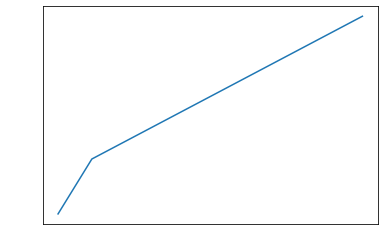

In [ ]:
K, misclassification_rate = [1, 5, 10], []

for k in K:
    dw_knn = DistW_KNearestNeighbors(n_neighbors=k)
    _ = dw_knn.fit(X_train, y_train)
    y_pred = dw_knn.predict(X_test)
    misclassification_rate.append(np.mean(y_pred != y_test))

plt.plot([1/k for k in K], misclassification_rate)


# Q8



One posible solution to the problem could be normalization.
A simple form of it might be the following linear transformation

we define vector x as the input and vector y as the output

y = (x - min(x)) / (max(x) - min(x))




